# SortingComponents Overview Tutorial

Author: Paul Adkisson

The ``spikeinterface.sortingcomponents`` module breaks up the sorting process into distinct steps or components.  This allows users to easily build their own spike sorting pipelines by mixing and matching existing components or swapping one (or more) out with their own version(s).  We are also developing benchmarks to objectively evaluate performance for each component separately.

DISCLAIMER: This module is under heavy development -- signatures and behaviors may change form time to time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colormaps
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
%matplotlib inline
from pathlib import Path
import warnings
warnings.simplefilter("ignore")
from tqdm.notebook import tqdm
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks
from spikeinterface.sortingcomponents.peak_selection import select_peaks
from spikeinterface.sortingcomponents.clustering import find_cluster_from_peaks
from spikeinterface.sortingcomponents.matching import find_spikes_from_templates

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Download the Data

For this tutorial, we will use a Neuropixels dataset freely available on DANDI ([sub-npI1_ses-20190413_behavior+ecephys.nwb](https://dandiarchive.org/dandiset/000053/0.210819.0345/files?location=sub-npI1%2F))

## Load, Preprocess & Visualize Data

For this tutorial we will breeze through the initial data reading, preprocessing, and visualization since these are all implemented in other spikeinterface modules.  If you need a refresher on any of these steps, please see appropriate tutorials/documentation.

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


recording = NwbRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 4732.300s
  file_path: /Volumes/T7/CatalystNeuro/TutorialDatasets/sub-npI1_ses-20190413_behavior+ecephys.nwb


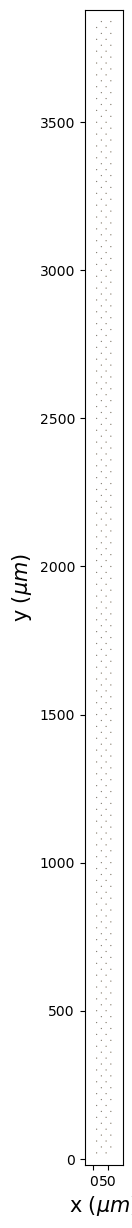

In [2]:
basepath = Path("/Volumes/T7/CatalystNeuro")
filepath = basepath / "TutorialDatasets/sub-npI1_ses-20190413_behavior+ecephys.nwb"
basepath = basepath / "SortingComponentsTutorial"
if not basepath.exists():
    basepath.mkdir()
recording = se.read_nwb(filepath)
print("recording =", recording)
fig, ax = plt.subplots(figsize=(10, 15))
_ = sw.plot_probe_map(recording, ax=ax)

This dataset has a probe with 384 channels on a single shank as visualized above.

Preprocessing should take ~6mins

rec10mins =  FrameSliceRecording: 384 channels - 1 segments - 30.0kHz - 600.000s
write_binary_recording with n_jobs = 4 and chunk_size = 30000


write_binary_recording:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

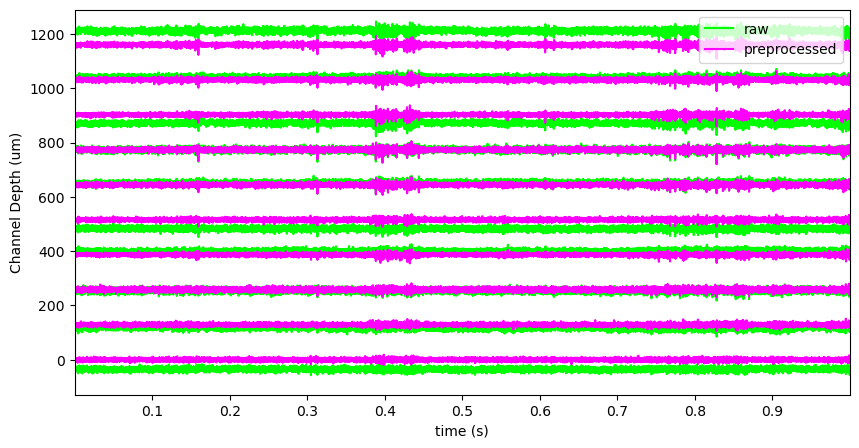

In [3]:
# Handy kwargs for parallel computing
job_kwargs = dict(n_jobs=4, chunk_duration="1s", progress_bar=True)

# We use only the first 10mins for speed
rec10mins = recording.frame_slice(start_frame=0, end_frame=recording.sampling_frequency*10*60)
print("rec10mins = ", rec10mins)
rec_filt = spre.bandpass_filter(rec10mins, freq_min=300., freq_max=6000.,
                                dtype='float32') # tridesclous template matching requires float32 dtype
rec_pproc = spre.common_reference(rec_filt, reference='global', operator='median')
# Cache output to perform the preprocessing computation up-front rather than lazily
preprocpath = basepath / "preproc"
if not preprocpath.exists():
    rec_pproc.save(folder=preprocpath, **job_kwargs)
rec_reloaded = sc.load_extractor(preprocpath)
  
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel("Channel Depth (um)")
_ = sw.plot_timeseries({"raw":rec10mins, "preprocessed":rec_pproc}, channel_ids=recording.channel_ids[50:60], ax=ax)

Above we can see a short snippet of the raw and preprocessed voltage traces

## Peak Detection

The classical first step of a spike sorting pipeline is detecting the prospective spikes, which is implemented in spikeinterface in ``spikeinterface.sortingcomponents.peak_detection.detect_peaks``.  Here we will compare a couple common approaches:
- 'by_channel' which detects peaks independently on each channel
- 'locally_exclusive' which detects peaks in a local neighborhood of a parameterized size

Peak Detection should take approximately 5mins / method

In [4]:
# To detect peaks properly we need the channel noise levels
noise_levels = sc.get_noise_levels(rec_pproc, return_scaled=False)
# handy common peak detection kwargs
detect_kwargs = dict(peak_sign='neg', detect_threshold=5, exclude_sweep_ms=0.2, noise_levels=noise_levels)
detect_methods = ['by_channel', 'locally_exclusive']
detected_peaks = {}
for method in detect_methods:
    printmd(f"### Method: {method}")
    peaks = detect_peaks(rec_pproc, method=method, **detect_kwargs, **job_kwargs)
    detected_peaks[method] = peaks
    
print("peaks.shape =", peaks.shape)
print("peaks.dtype =", peaks.dtype)

### Method: by_channel

detect peaks:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namesp

### Method: locally_exclusive

detect peaks:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

peaks.shape = (800731,)
peaks.dtype = [('sample_ind', '<i8'), ('channel_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')]


As we can see, the returned peaks are structured numpy arrays with fields
- 'sample_ind' : the time index of each peak
- 'channel_ind' : the channel index of each peak
- 'amplitude' : the spike amplitude (uV)
- 'segment_ind' : the segment index of each peak

In [5]:
print("# of peaks detected 'by channel': {:,.0f}".format(detected_peaks['by_channel'].shape[0]))
print("# of peaks detected 'locally exclusive': {:,.0f}".format(detected_peaks['locally_exclusive'].shape[0]))

# of peaks detected 'by channel': 1,783,531
# of peaks detected 'locally exclusive': 800,731


First, we note that detecting peaks by the 'locally exclusive' method returns far fewer potential spikes.  This is because it excludes nearby channels from double-counting the same spike (within radius ``local_radius_um``).

Now, Let's see how the amplitudes of the detected peaks differ.

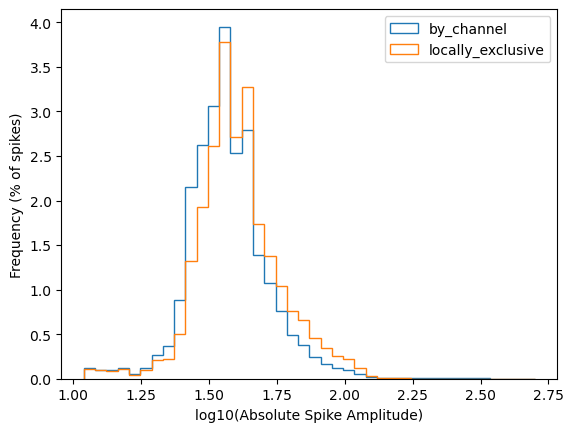

In [6]:
hist_kwargs = dict(bins=40, histtype='step', density=True)
plt.figure()
for method in detect_methods:
    peaks = detected_peaks[method]
    plt.hist(np.log10(np.abs(peaks['amplitude'])), **hist_kwargs, label=method)
plt.xlabel("log10(Absolute Spike Amplitude)")
plt.ylabel("Frequency (% of spikes)")
_ = plt.legend(loc="upper right")

From the histogram above we can see a log-normal spike amplitude distribution, which is typical for neural recordings.  Both methods detect a similar distribution of peaks, but 'locally_exclusive' is shifted slightly toward higher-amplitude peaks.  This is likely due to the 'locally_exclusive' method omitting lower-amplitude peaks from channels adjacent to the principal channel.

## Peak Localization

Many developed spike sorters require peak locations to appropriately cluster individual units localized in space.  We will compare several peak localization methods implemented in ``spikeinterface.peak_localization.localize_peaks``.

Center-of-mass localization takes ~1min

Monopolar Triangulation takes ~30mins

In [8]:
detect_method = "locally_exclusive"# we will use this method because it gave the best results
peaks = detected_peaks[detect_method]
# Handy kwargs for localizing peaks
localize_kwargs = dict(local_radius_um=150, ms_before=0.3, ms_after=0.6)

localize_methods = ['center_of_mass', 'monopolar_triangulation']
localized_peaks = {}
for method in localize_methods:
    printmd(f"### Method: {method}")
    localized_path = basepath / f"peak_locations_{method}.npy"
    if not localized_path.exists():
        peaklocs = localize_peaks(rec_pproc, peaks, method=method, **localize_kwargs, **job_kwargs)
        np.save(localized_path, peaklocs)
    else:
        peaklocs = np.load(localized_path)
    localized_peaks[method] = peaklocs

display("localized_peaks (center-of-mass) =", localized_peaks["center_of_mass"])
display("localized_peaks (monopolar triangulation) =", localized_peaks["monopolar_triangulation"])

### Method: center_of_mass

### Method: monopolar_triangulation

'localized_peaks (center-of-mass) ='

array([(35.64208243, 1415.92190889), (35.04214963, 1456.67017914),
       (35.77069199, 1606.40434193), ..., (31.5410628 , 1381.85990338),
       (36.07428571, 1291.34285714), (32.67965368, 1223.95382395)],
      dtype=[('x', '<f8'), ('y', '<f8')])

'localized_peaks (monopolar triangulation) ='

array([( 72.21099112, 1437.13818762, 83.21620827, 3728.95684897),
       ( 79.0299494 , 1404.6952169 , 84.9021111 , 4143.96712694),
       ( 54.52154879, 1599.95871761, 70.45611529, 2504.06090923), ...,
       ( 20.43478997, 1368.51431671,  1.84956938, 1369.5808183 ),
       ( 60.57429412, 1289.43655461, 22.23317634, 1514.16070403),
       (-37.00671782, 1267.65580644, 65.00866755, 3007.80239311)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('alpha', '<f8')])

As we can see here, the returned peak locations are structured numpy arrays.  The center-of-mass method performs a simple weighted average of peak amplitudes and returns fields
- 'x' : Horizontal Location (breadth in um)
- 'y' : Vertical Location (depth in um)

The monopolar triangulation method performs least-squares optimization on the peak amplitudes to distinguish between nearby low-amplitude spikes and far away high-amplitude spikes that might present the same amplitude on the principal channel. So, it adds two additional fields
- 'z' : Perpendicular Distance to the probe (um)
- 'alpha' : Estimated Amplitude at the source (uV)

Each entry corresponds to the same indexed peak in the input peaks array.

In [9]:
print("# of peaks localized 'center-of-mass': {:,.0f}".format(localized_peaks['center_of_mass'].shape[0]))
print("# of peaks localized 'monopolar triangulation': {:,.0f}".format(
    localized_peaks['monopolar_triangulation'].shape[0]))

# of peaks localized 'center-of-mass': 800,731
# of peaks localized 'monopolar triangulation': 800,731


Let's visualize the estimated locations on the probe!

(-240.0, 300.0)

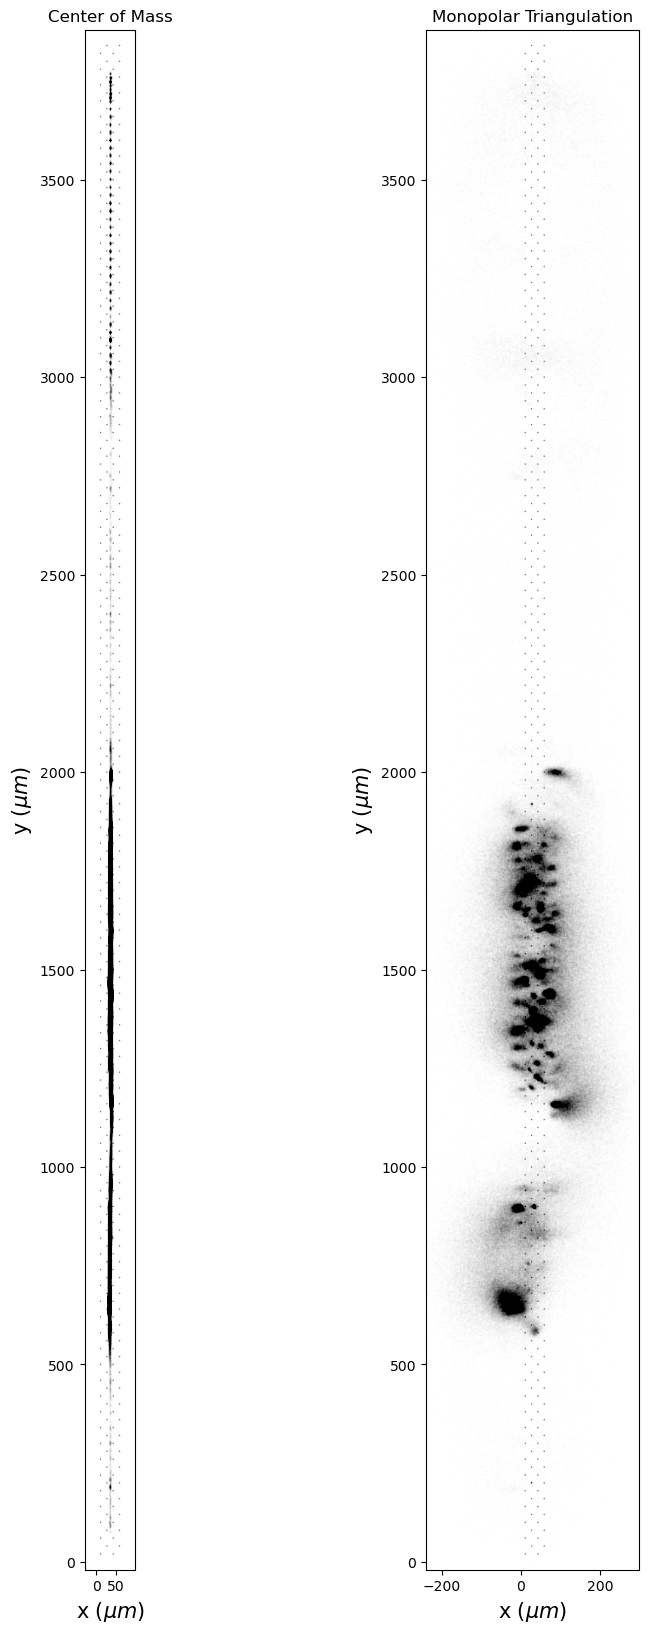

In [10]:
localize_titles = {'center_of_mass': "Center of Mass", 'monopolar_triangulation':"Monopolar Triangulation"}
fig, ax = plt.subplots(1, len(localize_methods), figsize=(10, 20))
for i, method in enumerate(localize_methods):
    sw.plot_probe_map(rec_pproc, ax=ax[i])
    peaklocs = localized_peaks[method]
    ax[i].scatter(peaklocs['x'], peaklocs['y'], color="k", s=1, alpha=0.005)
    ax[i].set_title(localize_titles[method])

xlims = [-240, 300]
ax[1].set_xlim(xlims)

From the 2D plot alone, we can see that monopolar triangulation creates distinct clouds of spikes that will be useful for clustering.  The center-of-mass method tends to aggregate all the locations toward the center of the probe and cannot assign spike location outside the bounds of the probe.  

Let's see what additional information is provided in the 2 extra fields from monopolar triangulation

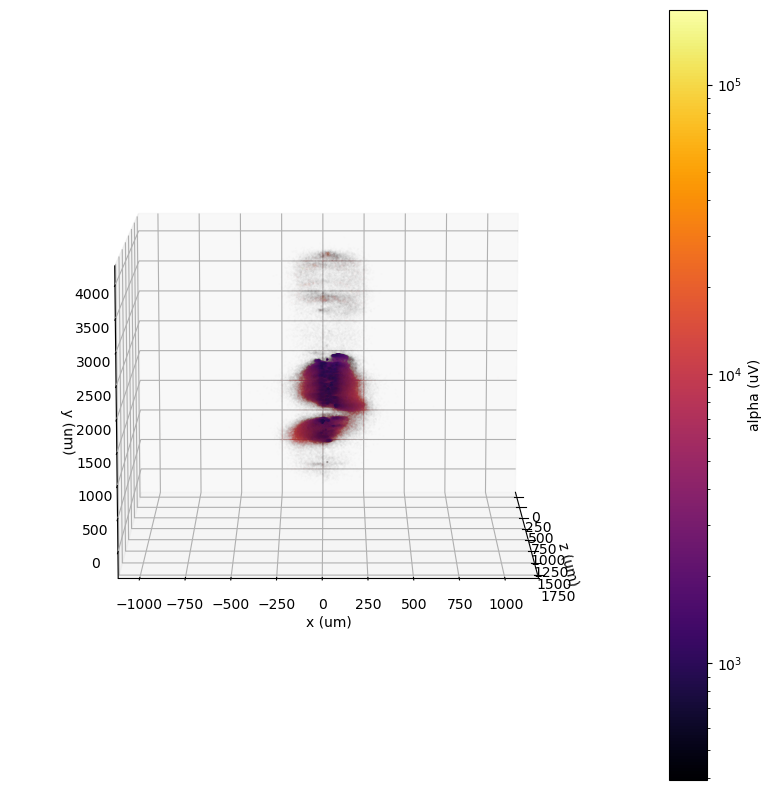

In [11]:
peaklocs = localized_peaks['monopolar_triangulation']
min_alpha = np.min(peaklocs['alpha'])
max_alpha = np.max(peaklocs['alpha'])
norm = LogNorm(vmin=min_alpha, vmax=max_alpha)
inferno = colormaps['inferno']
mappable = ScalarMappable(norm=norm, cmap=inferno)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(peaklocs['z'], peaklocs['x'], peaklocs['y'],
           c=peaklocs['alpha'], norm=norm, cmap=inferno, s=1, alpha=0.005)
ax.set_xlabel("z (um)")
ax.set_ylabel("x (um)")
ax.set_zlabel("y (um)")
ax.view_init(10, 0)
cbar = fig.colorbar(mappable, ax=ax, label="alpha (uV)")

We can see a wide range of source spike amplitudes (note the logarithmic color scale), and cloud-like blobs of spikes in 3D space.  Clearly, the extra time investment (~30mins vs ~1min) for monopolar triangulation provided important new information.

## Peak Selection 

Since we used a high-density Neuropixels probe, we detected 800,731 spikes in only a 10-minute recording.  Unfortunately, clustering algorithms tend to be quite slow and struggle to handle large numbers of spikes (ex. kmeans has a time complexity of $\mathcal{O}(n^2)$).  

To get around this problem, many modern spike sorters select a subset of these peaks to use for clustering.  The *way* in which these peaks are sampled is a critical step to ensure that no units are lost during this process.  We will compare several methods already implemented in ``spikeinterface.sortingcomponents.peak_selection.select_peaks``

In [12]:
peaks = detected_peaks[detect_method]
localize_method = 'monopolar_triangulation' # we will use this method because it gave the best results
peaklocs = localized_peaks[localize_method]
select_methods = ["uniform", "smart_sampling_amplitudes", "smart_sampling_locations"]
select_kwargs = dict(n_peaks = 10_000, noise_levels=noise_levels, by_channel=False)
selected_peaks = {}
for method in select_methods:
    printmd(f"### Method: {method}")
    if 'locations' in method:
        selected_peaks[method] = select_peaks(peaks, method=method, peaks_locations=peaklocs, seed=0,
                                              **select_kwargs)
    else:
        selected_peaks[method] = select_peaks(peaks, method=method, **select_kwargs)
print("peaks.shape=", selected_peaks['uniform'].shape)
print("peaks.dtype=", selected_peaks['uniform'].dtype)

### Method: uniform

### Method: smart_sampling_amplitudes

### Method: smart_sampling_locations

peaks.shape= (10000,)
peaks.dtype= [('sample_ind', '<i8'), ('channel_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')]


As expected, ``select_peaks`` returns a structured numpy array with the same fields as the peaks input, but subsampled to only ``n_peaks``.

Let's see how the amplitudes of the sampled peaks compare to the base distribution

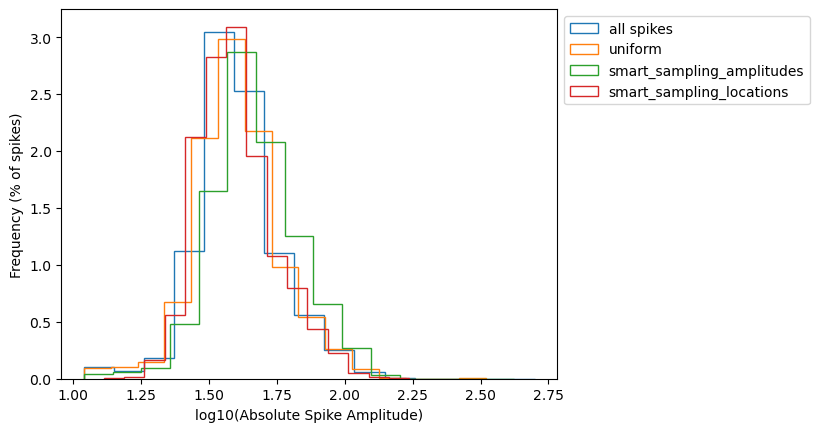

In [13]:
hist_kwargs = dict(histtype='step', bins=15, density=True)
plt.figure()
plt.hist(np.log10(np.abs(detected_peaks[detect_method]['amplitude'])), label="all spikes", **hist_kwargs)
for method in select_methods:
    plt.hist(np.log10(np.abs(selected_peaks[method]['amplitude'])), **hist_kwargs, label=method)
plt.xlabel("log10(Absolute Spike Amplitude)")
plt.ylabel("Frequency (% of spikes)")
_ = plt.legend(bbox_to_anchor=(1, 1))

All sampling methods roughly maintain the spike amplitude distribution.  The 'smart_sampling_amplitudes' method appears to mildly over-sample the high-amplitude spikes at the expense of the low-amplitude spikes.

Let's look at the location distributions as well

In [14]:
# relocalizing peaks in each subset
selected_peaklocs = {}
for method in select_methods:
    printmd(f"### Method: {method}")
    peaks = selected_peaks[method]
    peaklocs = localize_peaks(rec_pproc, peaks, method=localize_method,
                                          **localize_kwargs, **job_kwargs)
    selected_peaklocs[method] = peaklocs

### Method: uniform

localize peaks:   0%|          | 0/600 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_so

### Method: smart_sampling_amplitudes

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


localize peaks:   0%|          | 0/600 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespa

### Method: smart_sampling_locations

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


localize peaks:   0%|          | 0/600 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespac

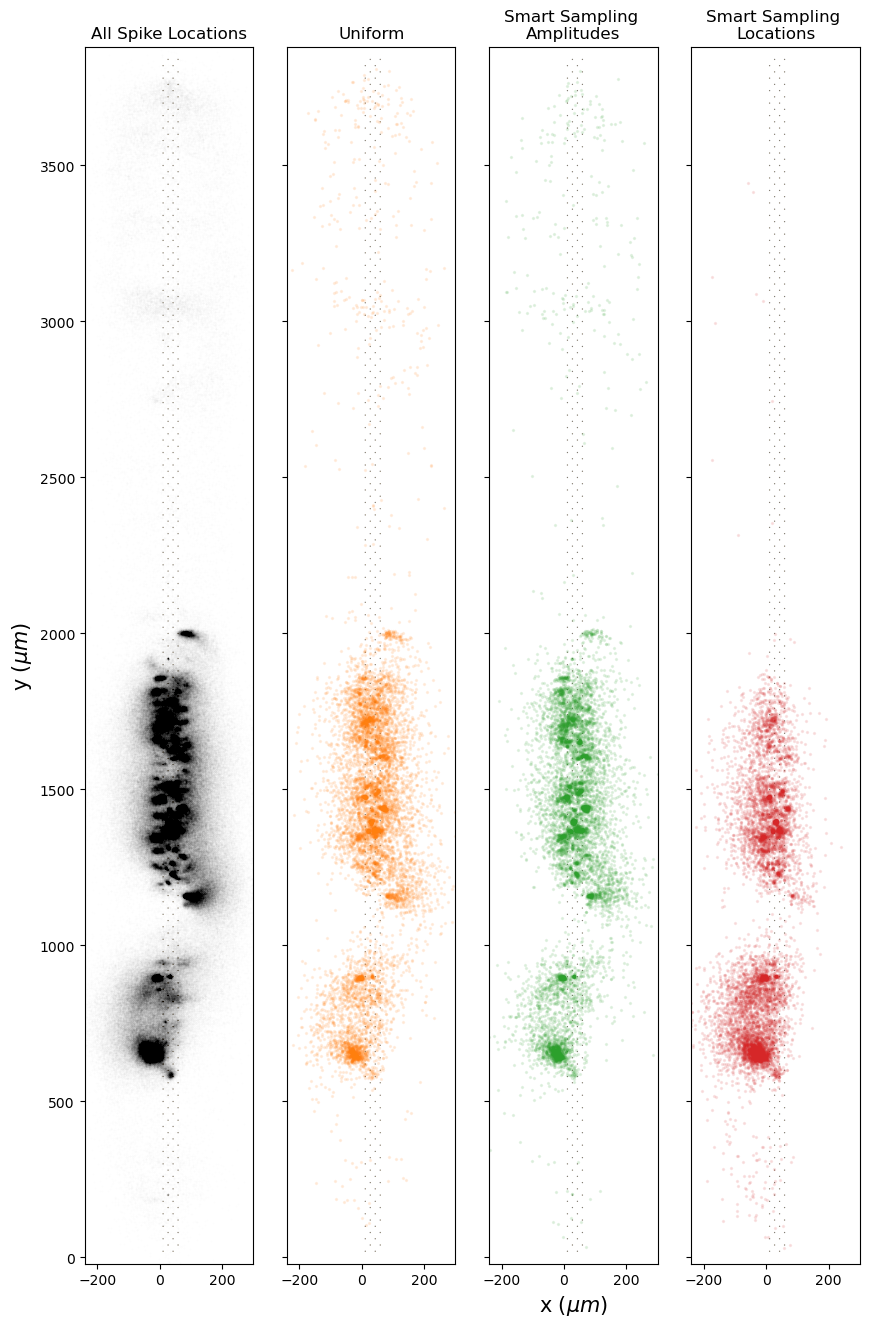

In [15]:
fig, ax = plt.subplots(1, len(select_methods)+1, figsize=(10, 20), sharey=True)
xlims = [-240, 300]
for i in range(len(select_methods)+1):
    sw.plot_probe_map(rec_pproc, ax=ax[i])

all_peaklocs = localized_peaks[localize_method]
ax[0].scatter(all_peaklocs['x'], all_peaklocs['y'], s=1, color="k", alpha=0.005)
ax[0].set_xlim(xlims)
ax[0].set_title("All Spike Locations")
method_titles = {"uniform":"Uniform",
                 "smart_sampling_amplitudes":"Smart Sampling \nAmplitudes",
                 "smart_sampling_locations":"Smart Sampling \nLocations"
                }
for i, method in enumerate(select_methods):
    peaklocs = selected_peaklocs[method]
    ax[i+1].scatter(peaklocs['x'], peaklocs['y'], color="C%i"%(i+1), s=2, alpha=0.1, label=method)
    ax[i+1].set_xlim(xlims)
    ax[i+1].set_title(method_titles[method])
    ax[i+1].set_ylabel("")
for i in [0, 1, 3]:
    ax[i].set_xlabel("")

From the plot above, we can see that all 3 peak selection methods capture a reasonable sample of the spike clouds in space.  Both 'uniform' and 'smart_sampling_amplitudes' sample an approximately equal number of spikes from each distinct cloud in space.  On the other hand 'smart_sampling_locations' favors the clouds in the lower half of the probe with higher spike counts at the expense of more sparse sampling of the diffuse cloud in the upper third of the probe (which is likely noise).

## Clustering

Clustering is the central step of spike sorting, and remains fertile territory for new innovations to improve spike sorters.  Historically, this step was split into feature extraction (ex. PCA on spike waveforms) and then clustering on those features (ex. kmeans).  But, in the spirit of *lazy* processing we decided to combine these two steps into one.  This decision allowed spikeinterface to compute feature extraction on-the-fly and avoid storage of large features.  

Here we will compare a few clustering methods already implemented in ``spikeinterface.sortingcomponents.clustering``

Clustering takes
- <1min for 'position'
- ~7mins for 'position_and_pca'
- ~7mins for 'sliding_hdbscan'

In [16]:
select_method = 'smart_sampling_locations' # we will use this method because it gave the best results
peaks = selected_peaks[select_method]
peaklocs = selected_peaklocs[select_method]
method_kwargs = dict(peak_locations=peaklocs)
cluster_labels = {}
cluster_methods = ['position', 'position_and_pca', 'sliding_hdbscan']
for method in cluster_methods:
    printmd(f"### Method: {method}")
    _, labels = find_cluster_from_peaks(rec_pproc, peaks, method_kwargs=method_kwargs, 
                                        method=method, **job_kwargs)
    cluster_labels[method] = labels
    
print("labels.shape =", labels.shape)
print("labels.dtype =", labels.dtype)

### Method: position

### Method: position_and_pca

extract waveforms shared_memory with n_jobs = 8 and chunk_size = 6510


/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' ve

extract waveforms shared_memory:   0%|          | 0/2765 [00:00<?, ?it/s]

rsion 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already load

Launching the local pca for splitting purposes
extract waveforms shared_memory with n_jobs = 8 and chunk_size = 6510


/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

extract waveforms shared_memory:   0%|          | 0/2765 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

### Method: sliding_hdbscan

extract waveforms shared_memory with n_jobs = 8 and chunk_size = 6510


/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

extract waveforms shared_memory:   0%|          | 0/2765 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

extract waveforms shared_memory with n_jobs = 8 and chunk_size = 6510


/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

extract waveforms shared_memory:   0%|          | 0/2765 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

labels.shape = (10000,)
labels.dtype = int64


As we can see, the returned peak labels are 1D numpy arrays with an integer label for each peak given to ``find_cluster_from_peaks``.  The ignored first argument contains the labels used for sorting, which are not used here.


Let's visualize the clustering output with their estimated locations.  We expect unit clusters to localize together in space.

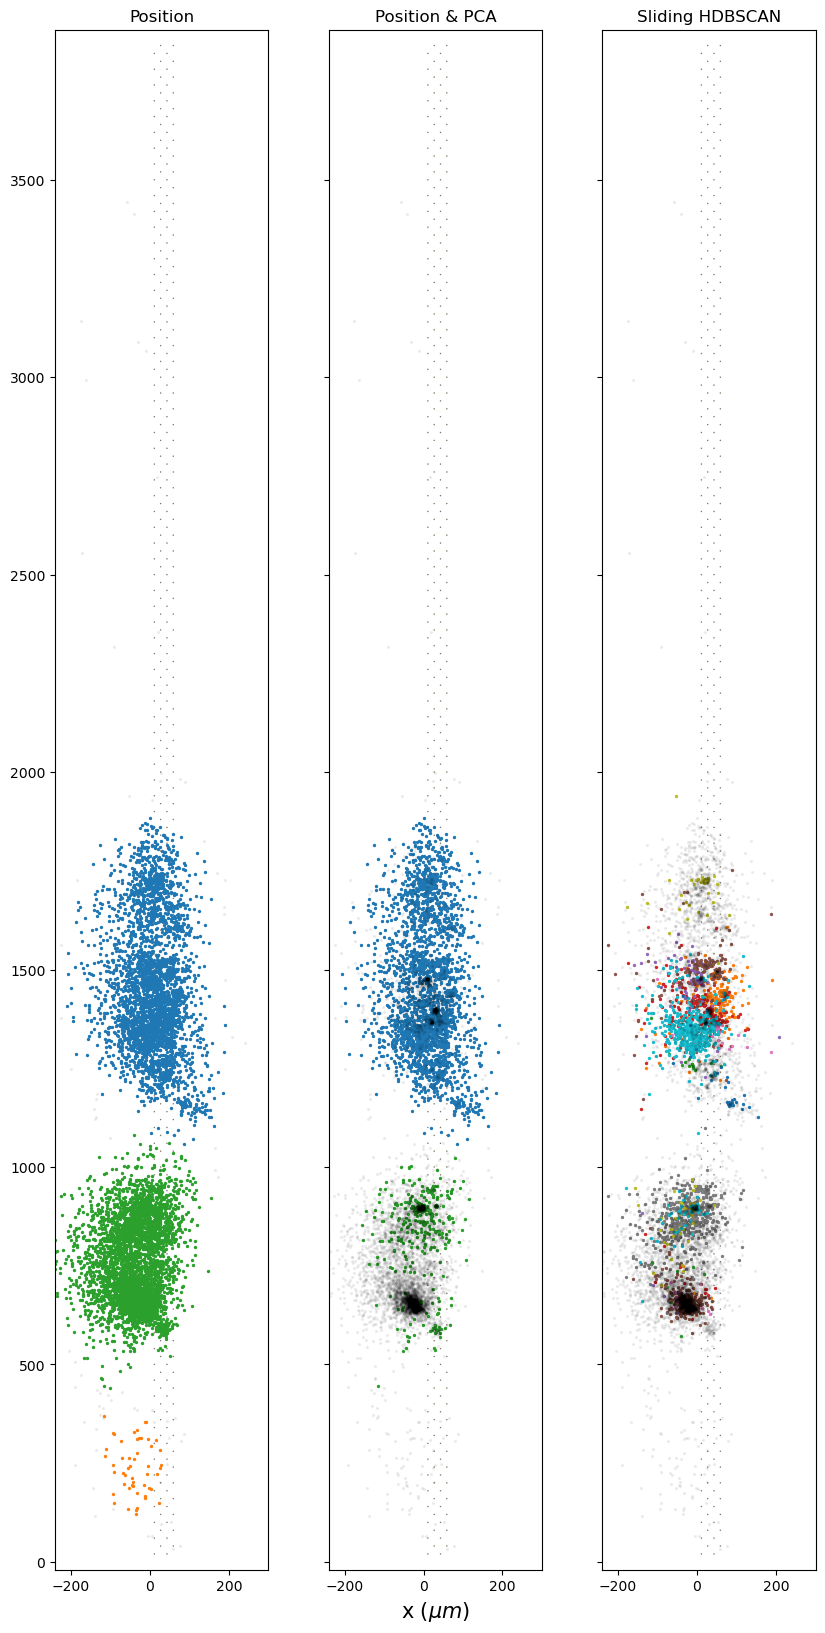

In [17]:
fig, ax = plt.subplots(1, len(cluster_methods), figsize=(10, 20), sharey=True)
for i in range(len(cluster_methods)):
    sw.plot_probe_map(rec_pproc, ax=ax[i])
cluster_titles = {"position":"Position",
                 "position_and_pca":"Position & PCA",
                 "sliding_hdbscan":"Sliding HDBSCAN"
                }
for i, method in enumerate(cluster_methods):
    labels = cluster_labels[method]
    for label in set(labels):
        peaklocs_clust = peaklocs[cluster_labels[method]==label]
        if label < 0: # labels < 0 correspond to noise clusters
            ax[i].scatter(peaklocs_clust['x'], peaklocs_clust['y'], color="k", s=2, alpha=0.05, label=label)
        else:
            ax[i].scatter(peaklocs_clust['x'], peaklocs_clust['y'], color=f"C{label}", s=2, alpha=1, label=label)

    ax[i].set_xlim(xlims)
    ax[i].set_title(cluster_titles[method])
    ax[i].set_ylabel("")
for i in [0, 2]:
    ax[i].set_xlabel("")

From the plots above, we can see that
- Positional clustering produces spatial clusters roughly as we would expect with minimal spikes designated as noise
- Position & PCA generated only one small cluster in the lower third of the probe with all other spikes designated as noise
- Sliding HDBSCAN split the two large clusters in the middle of the probe into many smaller ones, and designated all the other spikes as noise

In order to determine which of these approaches are the most reasonable, let's inspect the unit waveforms.

## Extract Waveforms & Visualize Templates

Waveform extraction and visualization are already implemented in spikeinterface in different modules, so we will employ those here.

First we convert the labels arrays to ``NpzSortingExtractor`` objects

In [18]:
cluster_sortings = {}
for method in cluster_methods:
    labels = cluster_labels[method]
    true_peaks = peaks[labels>=0]
    true_labels = labels[labels>=0] # omit noise clusters
    sorting = se.NumpySorting.from_times_labels(true_peaks['sample_ind'], true_labels, rec_pproc.sampling_frequency)
    sortpath = basepath / f"sorting_{method}.npz"
    se.NpzSortingExtractor.write_sorting(sorting, sortpath)
    sorting_extractor = se.NpzSortingExtractor(sortpath)
    cluster_sortings[method] = sorting_extractor
    print(cluster_sortings[method])

NpzSortingExtractor: 3 units - 1 segments - 30.0kHz
  file_path: /Volumes/T7/CatalystNeuro/SortingComponentsTutorial/sorting_position.npz
NpzSortingExtractor: 2 units - 1 segments - 30.0kHz
  file_path: /Volumes/T7/CatalystNeuro/SortingComponentsTutorial/sorting_position_and_pca.npz
NpzSortingExtractor: 19 units - 1 segments - 30.0kHz
  file_path: /Volumes/T7/CatalystNeuro/SortingComponentsTutorial/sorting_sliding_hdbscan.npz


Next we convert recording-sorting pairs to ``WaveformExtractor`` objects

Extracting Waveforms takes ~2min / method

In [19]:
wavepaths = {method : basepath / f"waveforms_{method}" for method in cluster_methods}
cluster_wes = {}
for method in cluster_methods:
    printmd(f"### Method: {method}")
    wavepath = wavepaths[method]
    sorting = cluster_sortings[method]
    we = sc.extract_waveforms(rec_pproc, sorting, wavepath, ms_before=1.5, ms_after=2, overwrite=True, **job_kwargs)
    cluster_wes[method] = we
    print(cluster_wes[method])

### Method: position

extract waveforms memmap:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' ve

WaveformExtractor: 384 channels - 3 units - 1 segments
  before:45 after:60 n_per_units:500


### Method: position_and_pca

extract waveforms memmap:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

WaveformExtractor: 384 channels - 2 units - 1 segments
  before:45 after:60 n_per_units:500


### Method: sliding_hdbscan

extract waveforms memmap:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

WaveformExtractor: 384 channels - 19 units - 1 segments
  before:45 after:60 n_per_units:500


Visualize waveforms

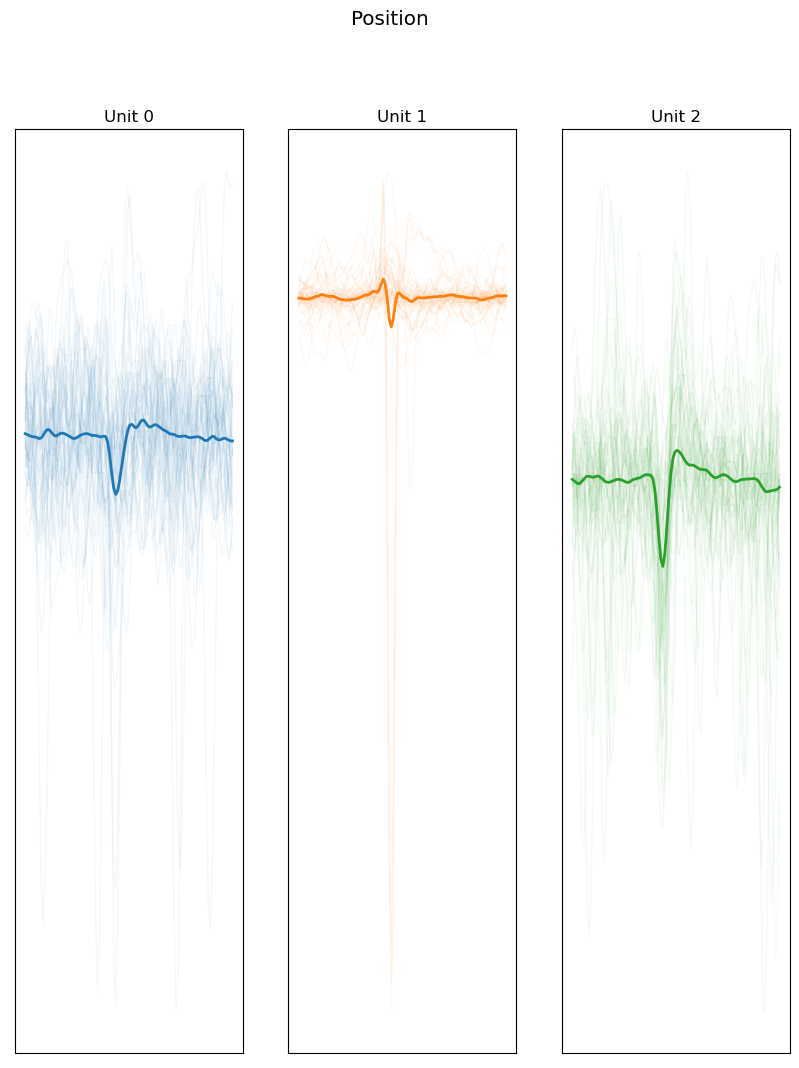

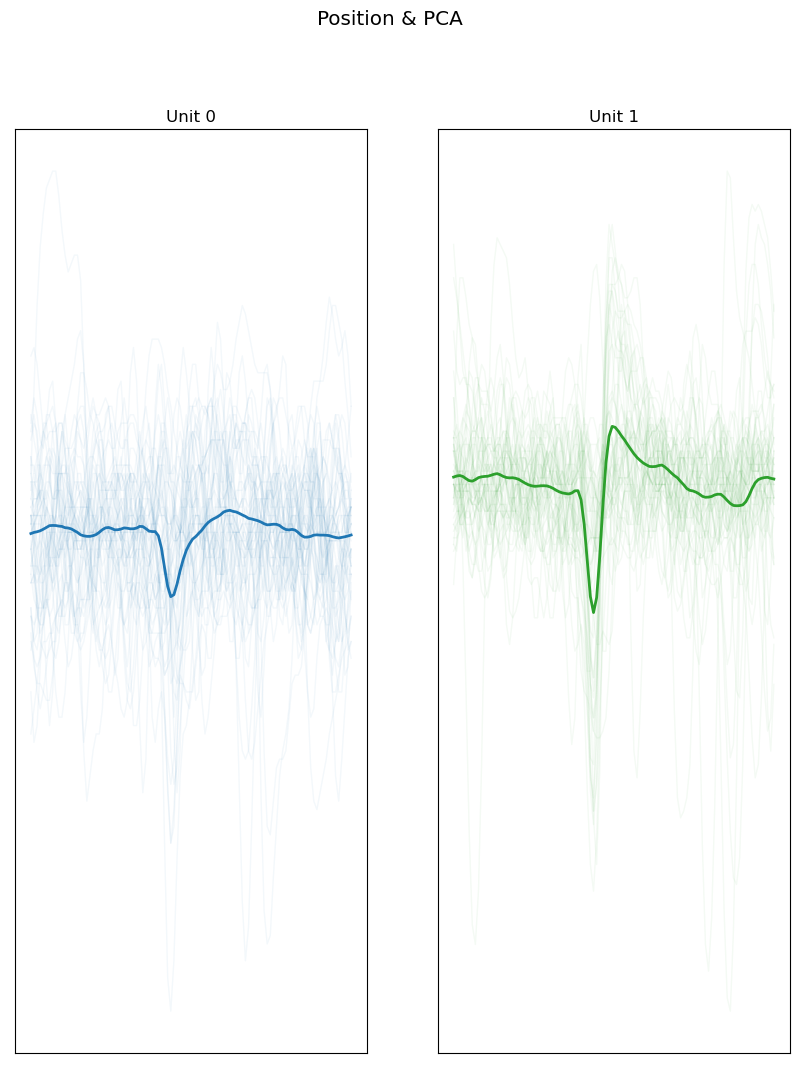

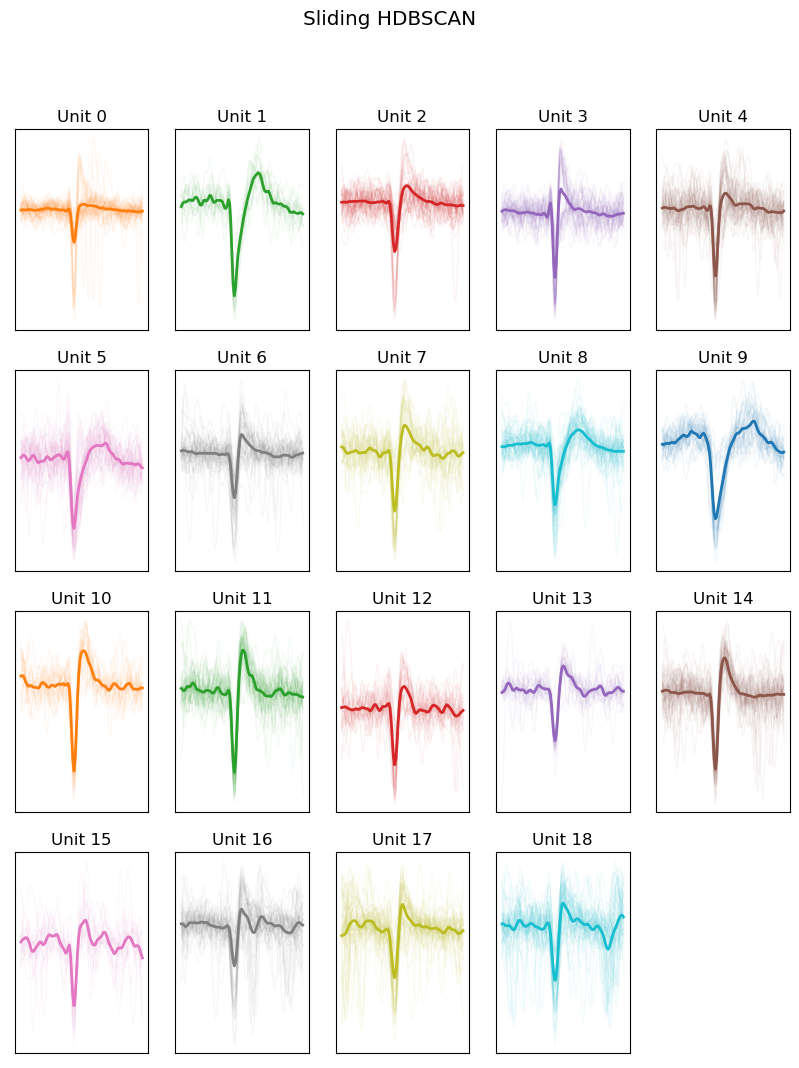

In [20]:
for method in cluster_methods:
    sorting = cluster_sortings[method]
    we = cluster_wes[method]
    sparsity = sc.ChannelSparsity.from_radius(we, radius_um=1) # only interested in pricipal channel waveforms
    unit_colors = {i:"C%i"%i for _, i in enumerate(sorting.unit_ids)}
    fig = plt.figure(figsize=(10, 12))
    sw.plot_unit_waveforms(we, unit_ids=sorting.unit_ids, sparsity=sparsity, max_spikes_per_unit=50,
                           alpha_waveforms=0.05, lw_templates=2, unit_colors=unit_colors, ncols=5, figure=fig)
    plt.suptitle(cluster_titles[method], fontsize='x-large')
    axes = fig.axes
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Unit {i}")

From the waveforms, we can see that the two clusters from the 'position' method are likely undersplit, each representing multiple units.  The 'position_and_pca' method seems to be missing many spikes that have been incorrectly designated as noise.  The 'sliding_hdbscan' method picks up many potential units, some of which look very similar, so this method may be oversplitting.  To investigate further we could employ some of the many tools in ``spikeinterface.qualitymetrics`` to assess the sorting quality.

For this tutorial, though, we will simply proceed with 'sliding_hdbscan' since it detected the most units.  We will rely on the template matching methods to re-cluster spikes appropriately.

## Template Matching

The final step of many spike sorting algorithms is to re-detect putative spikes using the templates built from previously clustered units.  Typically, these algorithms try to *explain* the voltage traces as a linear sum of templates plus some residual noise.  This allows spikes to be detected and automatically sorted even if they are co-occuring in time and space.

Here we will compare a few methods implemented in ``spikeinterface.sortingcomponents.template_matching``:
- 'naive': a naive template matching approach that simply uses the closest template
- 'tridesclous' : the template matching method from tridesclous
- 'circus' : the template matching method from spyking circus

Template matching takes
- ~5min for 'naive'
- ~7min for 'tridesclous'
- ~13min for 'circus'

In [21]:
cluster_method = 'sliding_hdbscan' # we will use this method because it gave the most units
we = cluster_wes[cluster_method]
tmatch_methods = ['naive', 'tridesclous', 'circus']
method_kwargs = {'naive':dict(waveform_extractor=we),
                 'tridesclous':dict(waveform_extractor=we, noise_levels=noise_levels, num_closest=3),
                 'circus':dict(waveform_extractor=we, noise_levels=noise_levels)}
tmatch_spikes = {}
for method in tmatch_methods:
    printmd(f"### Method: {method}")
    spikes = find_spikes_from_templates(rec_reloaded, method=method, method_kwargs=method_kwargs[method])
    tmatch_spikes[method] = spikes
    print("spikes.shape =", spikes.shape)
    print("spikes.dtype =", spikes.dtype)

### Method: naive

find spikes (naive):   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


spikes.shape = (66594,)
spikes.dtype = [('sample_ind', '<i8'), ('channel_ind', '<i8'), ('cluster_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')]


### Method: tridesclous

/Users/pauladkisson/Documents/CatalystNeuro/spikeinterface_source/spikeinterface/spikeinterface/postprocessing/template_tools.py:24: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()
/Users/pauladkisson/Documents/CatalystNeuro/spikeinterface_source/spikeinterface/spikeinterface/postprocessing/template_tools.py:25: DeprecationWarning: The 'get_template_channel_sparsity()' function is deprecated. Use 'compute_sparsity()' instead
  return tt.get_template_channel_sparsity(*args, **kwargs)
/Users/pauladkisson/Documents/CatalystNeuro/spikeinterface_source/spikeinterface/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


find spikes (tridesclous):   0%|          | 0/600 [00:00<?, ?it/s]

spikes.shape = (803052,)
spikes.dtype = [('sample_ind', '<i8'), ('channel_ind', '<i8'), ('cluster_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')]


### Method: circus

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


find spikes (circus):   0%|          | 0/600 [00:00<?, ?it/s]

spikes.shape = (108739,)
spikes.dtype = [('sample_ind', '<i8'), ('channel_ind', '<i8'), ('cluster_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')]


As we can already see, the returned `spikes` object is a structured numpy array with the same 4 fields as the earlier `peaks` arrays, but with one additional 'cluster_ind' field, which corresponds to the cluster label for that spike.

Another note is that of the three methods, 'naive' finds the fewest spikes (66,594), 'circus' finds more (110,410) and 'tridesclous' finds the most (417,288)

To get a better sense of the differences between these outputs, let's inspect the unit waveforms

Extracting Waveforms takes ~4min/method

In [22]:
# Generating SortingExtractor Objects from spikes
print("...Generating Sortings...")
tmatch_sortings = {}
for method in tmatch_methods:
    printmd(f"### Method: {method}")
    labels = tmatch_spikes[method]['cluster_ind']
    spiketime_inds = tmatch_spikes[method]['sample_ind']
    sorting = se.NumpySorting.from_times_labels(spiketime_inds, labels, rec_pproc.sampling_frequency)
    sortpath = basepath / f"tmatch_sorting_{method}.npz"
    se.NpzSortingExtractor.write_sorting(sorting, sortpath)
    sorting_extractor = se.NpzSortingExtractor(sortpath)
    tmatch_sortings[method] = sorting_extractor
    print(tmatch_sortings[method])
    
# Generating WaveformExtractor Objects from SortingExtractors
print("...Generating WaveformExtractors...")
tmatch_wavepaths = {method : basepath / f"tmatch_waveforms_{method}" for method in tmatch_methods}
tmatch_wes = {}
for method in tmatch_methods:
    printmd(f"### Method: {method}")
    wavepath = tmatch_wavepaths[method]
    sorting = tmatch_sortings[method]
    we = sc.extract_waveforms(rec_pproc, sorting, wavepath, ms_before=1.5, ms_after=2, overwrite=True, **job_kwargs)
    tmatch_wes[method] = we
    print(tmatch_wes[method])

...Generating Sortings...


### Method: naive

NpzSortingExtractor: 17 units - 1 segments - 30.0kHz
  file_path: /Volumes/T7/CatalystNeuro/SortingComponentsTutorial/tmatch_sorting_naive.npz


### Method: tridesclous

NpzSortingExtractor: 19 units - 1 segments - 30.0kHz
  file_path: /Volumes/T7/CatalystNeuro/SortingComponentsTutorial/tmatch_sorting_tridesclous.npz


### Method: circus

NpzSortingExtractor: 18 units - 1 segments - 30.0kHz
  file_path: /Volumes/T7/CatalystNeuro/SortingComponentsTutorial/tmatch_sorting_circus.npz
...Generating WaveformExtractors...


### Method: naive

extract waveforms memmap:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namesp

WaveformExtractor: 384 channels - 17 units - 1 segments
  before:45 after:60 n_per_units:500


### Method: tridesclous

extract waveforms memmap:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

WaveformExtractor: 384 channels - 19 units - 1 segments
  before:45 after:60 n_per_units:500


### Method: circus

extract waveforms memmap:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' ve

WaveformExtractor: 384 channels - 18 units - 1 segments
  before:45 after:60 n_per_units:500


Visualize Waveforms

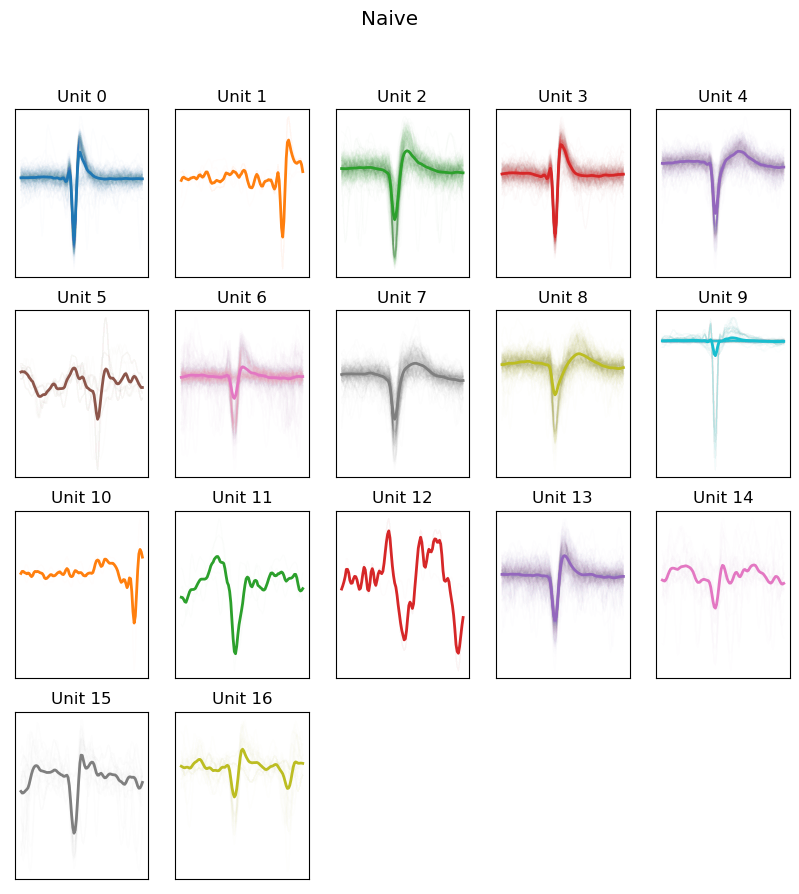

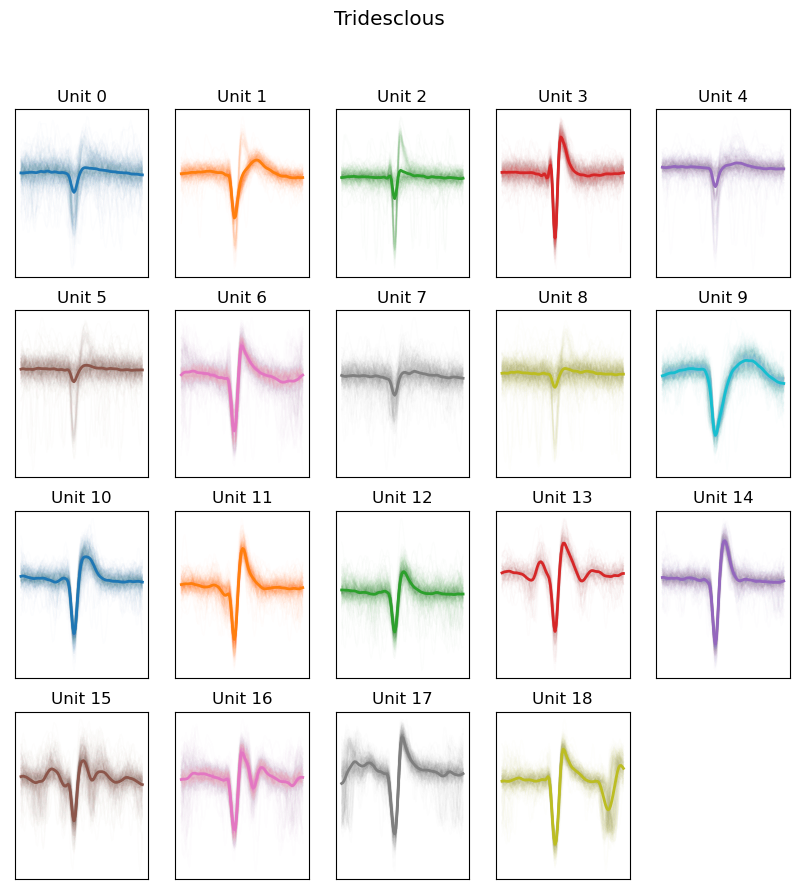

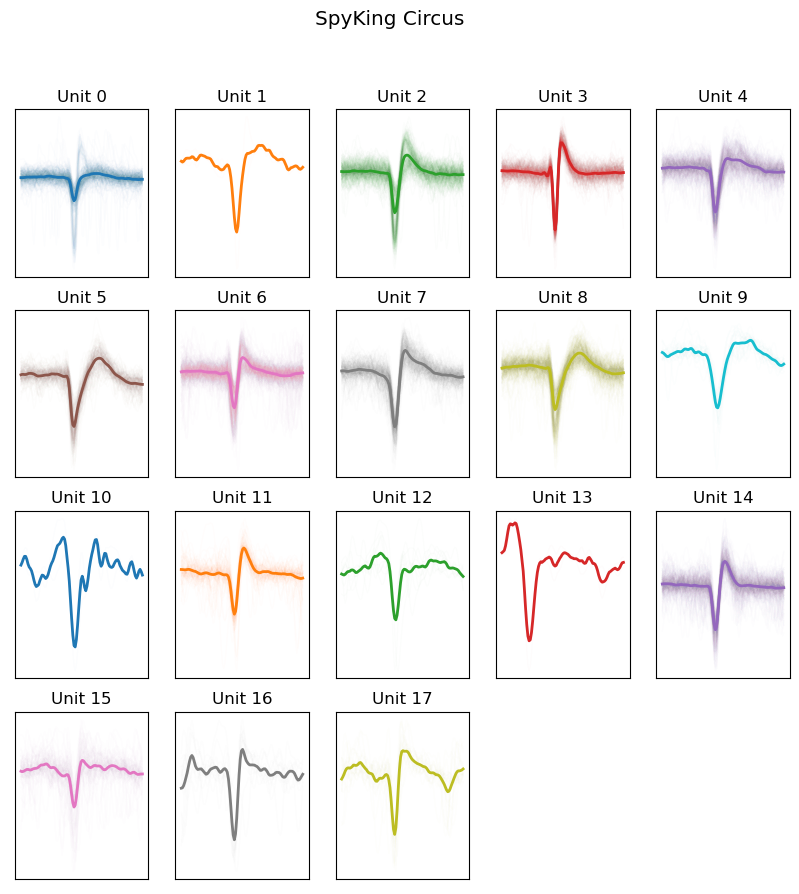

In [23]:
tmatch_titles = {'naive':"Naive", 'tridesclous':"Tridesclous", 'circus':"SpyKing Circus"}
for method in tmatch_methods:
    sorting = tmatch_sortings[method]
    we = tmatch_wes[method]
    sparsity = sc.ChannelSparsity.from_radius(we, radius_um=1) # only interested in pricipal channel waveforms
    unit_colors = {i:"C%i"%i for _, i in enumerate(sorting.unit_ids)}
    fig = plt.figure(figsize=(10, 10))
    sw.plot_unit_waveforms(we, unit_ids=sorting.unit_ids, sparsity=sparsity, max_spikes_per_unit=250,
                           alpha_waveforms=0.01, unit_colors=unit_colors, ncols=5, figure=fig)
    plt.suptitle(tmatch_titles[method], fontsize='x-large')
    axes = fig.axes
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Unit {i}")

From these visualizations, we can see that all three methods produced many apparently well-isolated units.

The 'naive' method contains a few very noisy templates that may correspond either to pure noise spikes or under-detected units with too few spikes to properly resolve the template waveform.  It also contains a few 'units' with 2 distinct spike amplitudes/timings that are strong candidates for splitting.

The 'tridesclous' method contains fewer of these problematic units.

The 'circus' method also contains few problematic units, but does not detect as many as 'tridesclous' and has some very similar units with small numbers of spikes possibly indicating over-splitting.

Note: Due to randomness, exact unit numbers may vary.

## Putting it all together

Now that we have explored each main component in the `sortingcomponents` module, we can combine our choices all together to create our own personalized spike sorting pipeline!

In [30]:
def cluster2waveform(recording, peaks, labels, path, job_kwargs=None): 
    '''Combines recording, peaks, and labels and repackages them into a waveform extractor
           with specified path'''
    if job_kwargs is None:
        job_kwargs = {}
    if not path.exists():
        path.mkdir()
        
    sorting = se.NumpySorting.from_times_labels(peaks['sample_ind'], labels, recording.sampling_frequency)
    sortpath = path / "sorting.npz"
    se.NpzSortingExtractor.write_sorting(sorting, sortpath)
    sorting_extractor = se.NpzSortingExtractor(sortpath)
    wavepath = path / "waveforms"
    we = sc.extract_waveforms(recording, sorting_extractor, wavepath,
                              ms_before=1.5, ms_after=2, overwrite=True, **job_kwargs)
    return we

def my_spikesorter(recording, path):
    # Setup
    job_kwargs = dict(n_jobs=4, chunk_duration="1s", progress_bar=True)
    recpath = path / "recording"
    if not recpath.exists():
        recording.save(folder=recpath, **job_kwargs)
    rec_reloaded = sc.load_extractor(recpath)
    
    # Peak Detection
    print("...Detecting Peaks...")
    noise_levels = sc.get_noise_levels(recording, return_scaled=False)
    detect_kwargs = dict(peak_sign='neg', detect_threshold=5, exclude_sweep_ms=0.2, noise_levels=noise_levels)
    peaks = detect_peaks(recording, method='locally_exclusive', local_radius_um=50,
                             **detect_kwargs, **job_kwargs)
    
    # Peak Localization
    print("...Localizing Peaks...")
    localize_kwargs = dict(local_radius_um=150, ms_before=0.3, ms_after=0.6)
    peaklocs = localize_peaks(recording, peaks, method='monopolar_triangulation',
                                  **localize_kwargs, **job_kwargs)
    
    # Peak Selection
    print("...Selecting Peaks...")
    select_kwargs = dict(n_peaks = 10_000, noise_levels=noise_levels, by_channel=False)
    peaks = select_peaks(peaks, method='smart_sampling_locations',
                         peaks_locations=peaklocs, **select_kwargs)
    peaklocs = localize_peaks(recording, peaks, method='monopolar_triangulation',
                                  **localize_kwargs, **job_kwargs)
    
    # Clustering
    print("...Clustering...") 
    _, labels = find_cluster_from_peaks(recording, peaks, method_kwargs=dict(peak_locations=peaklocs), 
                                        method="sliding_hdbscan", **job_kwargs)
    
    # Curating
    print("...Curating...")
    true_peaks = peaks[labels>=0]
    true_labels = labels[labels>=0] # omit noise clusters
    we = cluster2waveform(recording, true_peaks, true_labels, path, job_kwargs=job_kwargs)
    
    # Tempate Matching
    print("...Template Matching...")
    method_kwargs = dict(waveform_extractor=we, noise_levels=noise_levels, num_closest=3)
    spikes = find_spikes_from_templates(rec_reloaded, method='tridesclous', method_kwargs=method_kwargs)
    labels = spikes['cluster_ind']
    final_path = path / "final"
    we = cluster2waveform(recording, spikes, labels, final_path, job_kwargs=job_kwargs)
    return we

The full pipeline takes ~1hr

In [31]:
path = basepath / "my_spikesorter"
we = my_spikesorter(rec_pproc, path)

...Detecting Peaks...


detect peaks:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' ve

...Localizing Peaks...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


localize peaks:   0%|          | 0/600 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespac

...Selecting Peaks...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


localize peaks:   0%|          | 0/600 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespac

...Clustering...
extract waveforms shared_memory with n_jobs = 8 and chunk_size = 6510


/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

extract waveforms shared_memory:   0%|          | 0/2765 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-com

extract waveforms shared_memory with n_jobs = 8 and chunk_size = 6510


extract waveforms shared_memory:   0%|          | 0/2765 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namesp

...Curating...


extract waveforms memmap:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namesp

...Template Matching...


/Users/pauladkisson/Documents/CatalystNeuro/spikeinterface_source/spikeinterface/spikeinterface/postprocessing/template_tools.py:24: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()
/Users/pauladkisson/Documents/CatalystNeuro/spikeinterface_source/spikeinterface/spikeinterface/postprocessing/template_tools.py:25: DeprecationWarning: The 'get_template_channel_sparsity()' function is deprecated. Use 'compute_sparsity()' instead
  return tt.get_template_channel_sparsity(*args, **kwargs)
/Users/pauladkisson/Documents/CatalystNeuro/spikeinterface_source/spikeinterface/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


find spikes (tridesclous):   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/600 [00:00<?, ?it/s]

/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/sienv_source/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' ve

The full pipeline takes -3286.706556081772s


Now we have a full pipeline that can run end-to-end on the preprocessed recording object with a very compact definition (2-5 lines) to specify each step.  We selected each step by assessing it individually, but we could very easily swap components out based on their contribution to the final sorting output.

We conclude this tutorial by visualizing the resulting single-unit spike trains from our spikesorting pipeline.

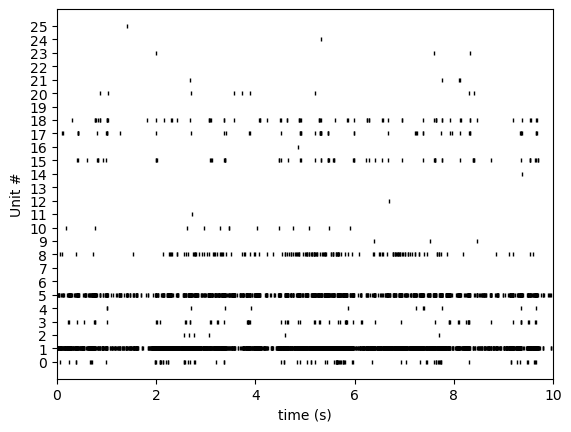

In [32]:
fig, ax = plt.subplots()
sw.plot_rasters(we.sorting, time_range=[0, 10], ax=ax)
_ = ax.set_ylabel("Unit #")

Write your post here.